Структура (для каждого индекса отдельно)
1. Картинки с наложением по блокам!
2. Снижение размерности
2. Log reg, NN, CNN

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from IPython.display import Image
from IPython.core.display import HTML 

In [24]:
import qgrid
# qgrid_widget=qgrid.show_grid(df,show_toolbar=True)
# df=qgrid_widget
# df.get_changed_df()

In [4]:
os.chdir(r'C:\Users\vkosarev\YandexDisk\2_disser_aspa\data\Сбор_Росстат')

In [6]:
os.chdir('/Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/data/Сбор_Росстат')

In [3]:
xl=pd.ExcelFile('mydata.xlsx')
nomex=xl.parse('nomex',skiprows=1,index_col='data',parse_dates=True)['curs']
ex=nomex.resample('M').mean()
brent=xl.parse('brent',skiprows=0,index_col='date',parse_dates=True)['close']
nf=brent.resample('M').mean()

In [6]:
x=xl.parse('inv')['inv'].values
#расшириям квартальные данные до месячных, помещяя значение на последний месяц квартала
a=list(range(0,len(x)))
x2=np.insert(x,a,[0]*len(a))#вставляем ноль сначала на каждое второе значение
a=[i for i in list(range(0,len(x2))) if i%2==0]
aa=np.insert(x2,a,[0]*len(a))#вставляем 0 на каждое 3 значение
xx=pd.date_range(start='2005-01-31',periods=174,dtype='datetime64[ns]', freq='M')
# pd.Series(aa,index=xx)

In [15]:
debt=xl.parse('credit',skiprows=1,index_col='data',parse_dates=True)
debt.index=[get_last_day(i) for i in debt.index]

In [20]:
CA_list=xl.parse('CA',skiprows=1,index_col='date',parse_dates=True)
CA_list.index=[get_last_day(i) for i in CA_list.index]
ca_x13=CA_list['X13final'].dropna()
ca_binar=CA_list['CA_binar'].dropna()

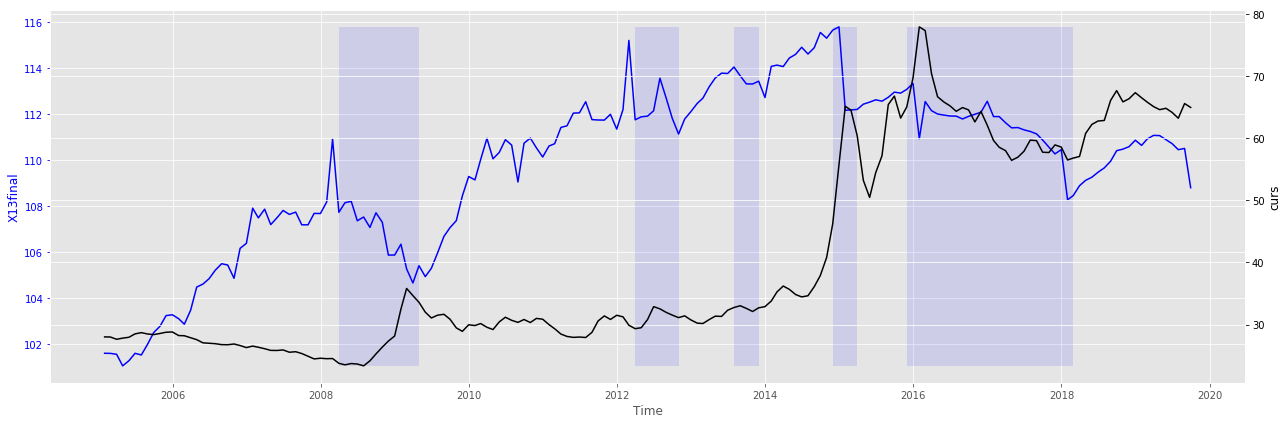

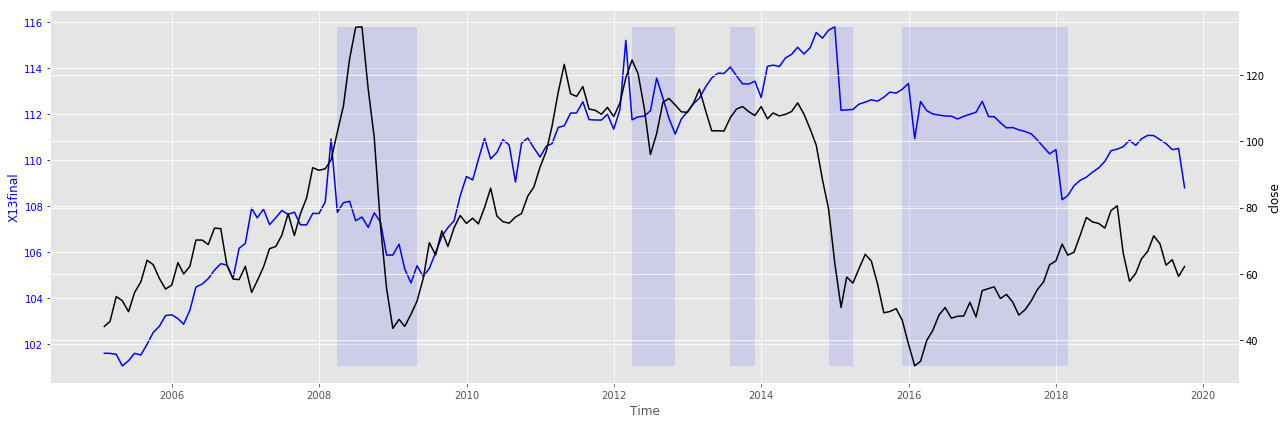

In [21]:
fplot(ca_x13.index, ca_x13,ex[:-1],ca_binar,1)
fplot(ca_x13.index, ca_x13,nf[:-1],ca_binar,1)

### CNN 

In [2]:
from numpy import hstack
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

from keras.utils import plot_model
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#для расчета roc-auc внутри нейронки
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

Using TensorFlow backend.


In [17]:
np.random.seed(42)#для воспроизводимости результатов
X_cnn_train1=np.random.random_sample((50000,12, 1))
X_cnn_train2=np.random.random_sample((50000,12, 3))

X_cnn_test1=np.random.random_sample((1000,12, 1))
X_cnn_test2=np.random.random_sample((1000,12, 3))

invest_train=np.random.random_sample((50000,4,3))
invest_test=np.random.random_sample((1000,4,3))

def y_sample(size):
    a=np.random.randint(2,size=size)
    return np.stack([a,1-a]).transpose()

y_cnn_train_re=y_sample(50000)
Y_cnn_test_re=y_sample(1000)

n_steps=12

In [4]:
# path='/Users/vladimirkosarev/Desktop/Yandex.Disk.localized/2_disser_aspa/Python/'
# Image(filename= path+"2019-11-15 12-47-26.JPG",width=500, height=100) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
PCA_result (InputLayer)         (None, 12, 3)        0                                            
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 4, 4)         40          PCA_result[0][0]                 
__________________________________________________________________________________________________
invest (InputLayer)             (None, 4, 3)         0                                            
__________________________________________________________________________________________________
Index_val (InputLayer)          (None, 12, 1)        0                                            
__________________________________________________________________________________________________
concatenat

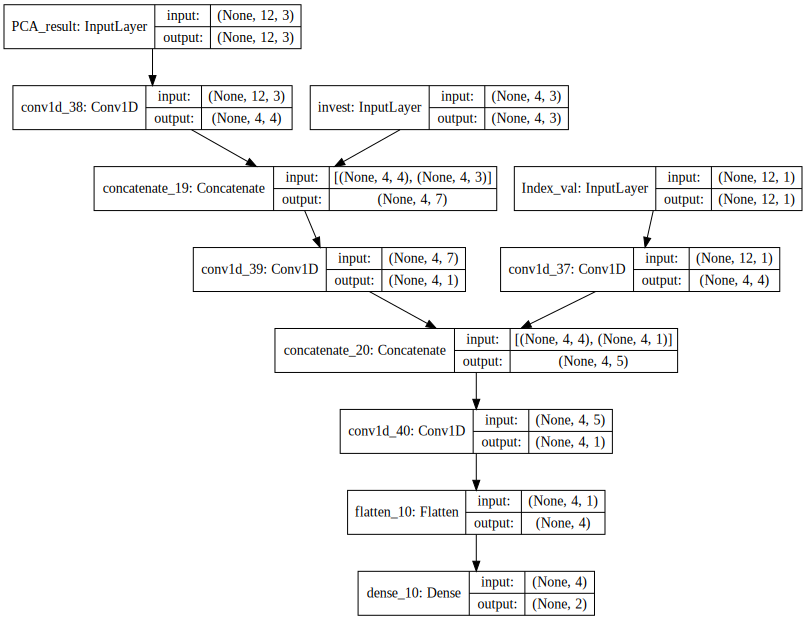

In [29]:
#1-d свертка всегда сворачивает в всю панель фаткоров в одно наблюдение.
n_features1 = X_cnn_train1.shape[2]
n_features2 = X_cnn_train2.shape[2]

visible1 = Input(shape=(n_steps, n_features1),name='Index_val')
cnn1 = Conv1D(filters=4, kernel_size=3,
#               padding='causal',
              dilation_rate=4,
              activation='relu',activity_regularizer=regularizers.l2(0.01))(visible1)

# second input model
visible2 = Input(shape=(n_steps, n_features2),name='PCA_result')
cnn2 = Conv1D(filters=4, kernel_size=3, 
#               padding='causal',
              dilation_rate=4,
              activation='relu',activity_regularizer=regularizers.l2(0.01))(visible2)
#чтоб не смешивать ряды между собой заранее нужно отдельный инпут тогда для каждого 

inv_inp = Input(shape=(4, 3),name='invest')
#сюда можно одновременно все квартальные показатели впихнуть, просто размерность будет (4,n)
# z = Add() ([cnn2,inv_inp])# а можно и так 
z = concatenate([cnn2,inv_inp],axis=-1)
out = Conv1D(filters=1, kernel_size=1,activation='relu',activity_regularizer=regularizers.l2(0.01))(z)

# merge input models
merge = concatenate([cnn1, out],axis=-1)
merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(merge)
merge = Flatten()(merge)
output = Dense(2, activation='sigmoid')(merge)
model = Model(inputs=[visible1, visible2,inv_inp], outputs=output)
model.summary()


SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='network2.png')

In [30]:
opt = Nadam(lr=0.001)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy',auc_roc])
checkpoint = ModelCheckpoint("weights.hdf5", monitor='auc_roc', mode='max', save_best_only=True, verbose=0)

history = model.fit([X_cnn_train1,X_cnn_train2,invest_train], y_cnn_train_re, 
          nb_epoch = 50, 
          batch_size = 10000, 
          verbose=1, 
          validation_data=([X_cnn_test1,X_cnn_test2,invest_test], Y_cnn_test_re),
          shuffle=False,
          callbacks=[checkpoint])

Train on 50000 samples, validate on 1000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 41us/step - loss: 338.6464 - acc: 0.5007 - auc_roc: 0.3994 - val_loss: 33.5772 - val_acc: 0.5210 - val_auc_roc: 0.4987
Epoch 2/50
50000/50000 [==============================] - 0s 6us/step - loss: 316.8823 - acc: 0.5019 - auc_roc: 0.4988 - val_loss: 31.3844 - val_acc: 0.5130 - val_auc_roc: 0.4989
Epoch 3/50
50000/50000 [==============================] - 0s 6us/step - loss: 294.6738 - acc: 0.5010 - auc_roc: 0.4989 - val_loss: 29.1232 - val_acc: 0.5150 - val_auc_roc: 0.4991
Epoch 4/50
50000/50000 [==============================] - 0s 5us/step - loss: 272.3738 - acc: 0.5015 - auc_roc: 0.4991 - val_loss: 26.9006 - val_acc: 0.5130 - val_auc_roc: 0.4992
Epoch 5/50
50000/50000 [==============================] - 0s 5us/step - loss: 250.8102 - acc: 0.5016 - auc_roc: 0.4992 - val_loss: 24.8228 - val_acc: 0.5120 - val_auc_roc: 0.4993
Epoch 6/50
50000/50000 [==============================]

50000/50000 [==============================] - 0s 6us/step - loss: 12.1184 - acc: 0.5022 - auc_roc: 0.4999 - val_loss: 1.8443 - val_acc: 0.5140 - val_auc_roc: 0.4999
Epoch 47/50
50000/50000 [==============================] - 0s 5us/step - loss: 11.5211 - acc: 0.5022 - auc_roc: 0.4999 - val_loss: 1.7848 - val_acc: 0.5140 - val_auc_roc: 0.4999
Epoch 48/50
50000/50000 [==============================] - 0s 7us/step - loss: 10.9657 - acc: 0.5022 - auc_roc: 0.4999 - val_loss: 1.7293 - val_acc: 0.5140 - val_auc_roc: 0.4999
Epoch 49/50
50000/50000 [==============================] - 0s 7us/step - loss: 10.4487 - acc: 0.5022 - auc_roc: 0.4999 - val_loss: 1.6775 - val_acc: 0.5140 - val_auc_roc: 0.4999
Epoch 50/50
50000/50000 [==============================] - 0s 7us/step - loss: 9.9663 - acc: 0.5022 - auc_roc: 0.4999 - val_loss: 1.6291 - val_acc: 0.5140 - val_auc_roc: 0.4999



last val_loss = 1.629
last accuracy = 0.514
last val_auc_roc = 0.5



['last val_loss = 1.629', 'last accuracy = 0.514', 'last val_auc_roc = 0.5']

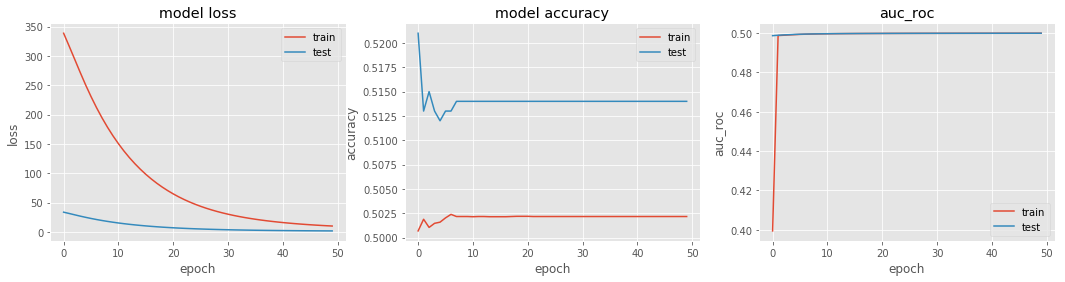

In [31]:
print_3plots(history)

In [ ]:
# roc_auc_pic(model, y_cnn_train_re, Y_cnn_test_re, X_train, X_test)
# model.predict_proba([X_cnn_train1,X_cnn_train2,invest_train])
model.predict([X_cnn_train1,X_cnn_train2,invest_train])
model.predict([X_cnn_test1,X_cnn_test2,invest_test])

### Function

In [8]:
def fplot(t,y1,y2,ipp_bin_sm3,n):
    fig, ax1 = plt.subplots(figsize=(18,6))
    ax1.plot(t,y1, 'b-')
    ax1.set_xlabel('Time')
    ax1.set_ylabel(y1.name, color='b')
    ax1.tick_params('y', colors='b')
    ax1.fill_between(t, min(y1), max(y1), where=ipp_bin_sm3 < 0,
                facecolor='blue', alpha=0.1)
    ax2 = ax1.twinx()
    s2 = y2.fillna(method='pad')
    ax2.plot(t,s2, 'k')
    ax2.set_ylabel(s2.name, color='black')
    ax2.tick_params('y', colors='black')
    fig.tight_layout()
#     plt.show()
#     fig.savefig('plots_final/figure'+str(n)+'.png')

In [14]:
from datetime import date, timedelta

def get_first_day(dt, d_years=0, d_months=0):
    y, m = dt.year + d_years, dt.month + d_months
    a, m = divmod(m-1, 12)
    return date(y+a, m+1, 1)

def get_last_day(dt):
    return get_first_day(dt,0,1)+timedelta(-1)

In [10]:
def sammary_acc(y_test,y_pred):
    # y_pred=np.array(pred_y_c)
    tp=0
    fp=0
    fn=0
    tn=0
    for i in np.array([y_test,y_pred]).T:
        if i[0]==1 and i[1]==1: tp+=1
        if i[0]==0 and i[1]==1: fp+=1
        if i[0]==1 and i[1]==0: fn+=1
        if i[0]==0 and i[1]==0: tn+=1
    print('','TP =',tp, 'FP =', fp,'\n','FN =', fn,'TN =', tn)
    return tp,fp,fn,tn

In [204]:
def roc_auc_pic(model, y_train, y_test, X_train, X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
import matplotlib.gridspec as gridspec
def print_3plots(history):
    fig2 = plt.figure(figsize=(18, 4))
    spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig2)
    ax1 = fig2.add_subplot(spec2[0, 0])
    ax2 = fig2.add_subplot(spec2[0, 1])
    ax3 = fig2.add_subplot(spec2[0, 2])

    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='best')

    ax2.plot(history.history['acc'])#точность процент правильно классифицированных примеров
    ax2.plot(history.history['val_acc'])
    ax2.set_title('model accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='best')

    ax3.plot(history.history['auc_roc'])#точность процент правильно классифицированных примеров
    ax3.plot(history.history['val_auc_roc'])
    ax3.set_title('auc_roc')
    ax3.set_ylabel('auc_roc')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'test'], loc='best')
    # fig.savefig(str(pp)+'foo2.png') 

#     print ('Отношение числа наблюдений к кол-ву оцениваемых параметров:{}'.format(round((X_train.shape[0]*X_train.shape[1])/size(model),2)))
    print ()
    b1='last val_loss = {}'.format(round(history.history['val_loss'][-1],3))
    print(b1)
    b2='last accuracy = {}'.format(round(history.history['val_acc'][-1],3))
    print(b2)
    b3='last val_auc_roc = {}'.format(round(history.history['val_auc_roc'][-1],3))
    print(b3)
    print()
    return [b1,b2,b3]